In [1]:
from PIL import Image
import numpy as np
from module.utility import show_images
from common.utility import show_implementation

In [2]:
rose_image = Image.open("images/rose.jpg")
rose_image_grey = rose_image.convert("L")
rose_image_rgb = rose_image.convert("RGB")

# Digital Image
In digital image, the image data is usually stored as a grid of pixel values.
Each value corresponds to the intensity of the pixel, larger being more intense.

Since both the intensity and location of light rays captured by a camera is continuous, there will be discretization of both the pixel intensity and pixel location when converting to a digital image.
The intensity value usually range from 0-255, which corresponds to an 8-bit integer.

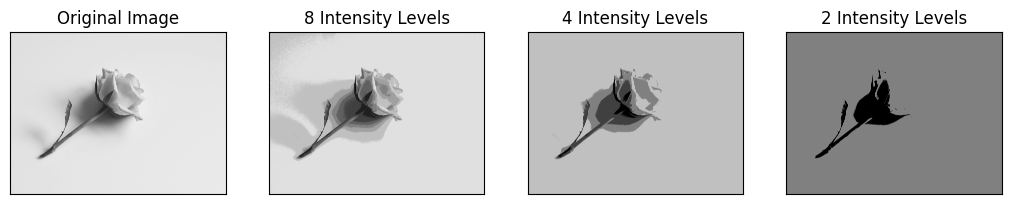

In [3]:
from module.discretize import discretize_color

show_images(
    [
        (
            discretize_color(rose_image_grey, i),
            "Original Image" if i == 256 else f"{i} Intensity Levels",
        )
        for i in [256, 8, 4, 2]
    ]
)

Photo by Jess Bailey Designs from Pexels

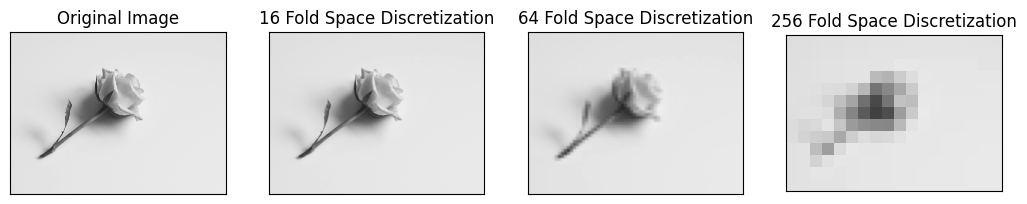

In [4]:
from module.discretize import discretize_space

show_images(
    [
        (
            discretize_space(rose_image_grey, i),
            "Original Image" if i == 1 else f"{i} Fold Space Discretization",
        )
        for i in [1, 16, 64, 256]
    ]
)

## Coordinates

As convention, we define the coordinate of the top-left pixel as (0,0), with the first value being the y value and the 2nd value being the x.


## RGB Colourspace

Our previous discussion have assumed that we are using greyscale image.
However, they also apply for coloured images.
Typically, we can create coloured images by using 3 arrays of values, one for each of the Red, Green and Blue channel of the image.

Thus, a typical RGB image is stored as a 3D array, with `[y][x][channel]`

In [5]:
from module.rgb_to_grey import extract_channel

show_implementation(extract_channel)

def extract_channel(img, channel):
    return img[:, :, channel]


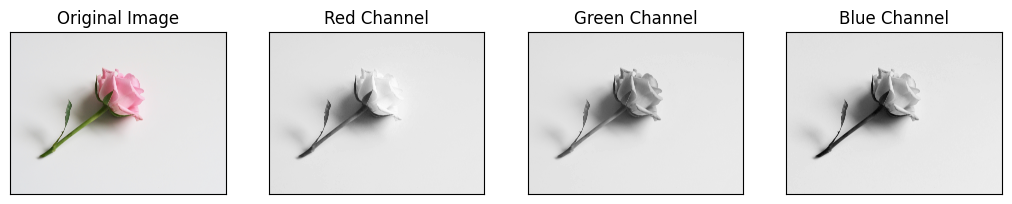

In [6]:
image = np.array(rose_image_rgb)

show_images(
    (image, "Original Image"),
    (extract_channel(image, 0), "Red Channel"),
    (extract_channel(image, 1), "Green Channel"),
    (extract_channel(image, 2), "Blue Channel"),
)

Notice that the pink parts of the flower appears white under the red channel, meaning that area has high red intensity.
Equivalently, the stem is lightest in the green channel.

## Conversion to Greyscale
A simple way to obtain a greyscale image is to take the average of the three channels.
However, we can also change the weights slightly, like using the ratio of 0.299, 0.587, 0.114 for RGB respectively, which follows closer to human vision.

In [7]:
from module.rgb_to_grey import to_greyscale

show_implementation(to_greyscale)

def to_greyscale(img, weights=(0.2989, 0.587, 0.114)):
    return img[:, :, 0] * weights[0] + img[:, :, 1] * weights[1] + img[:, :, 2] * weights[2]


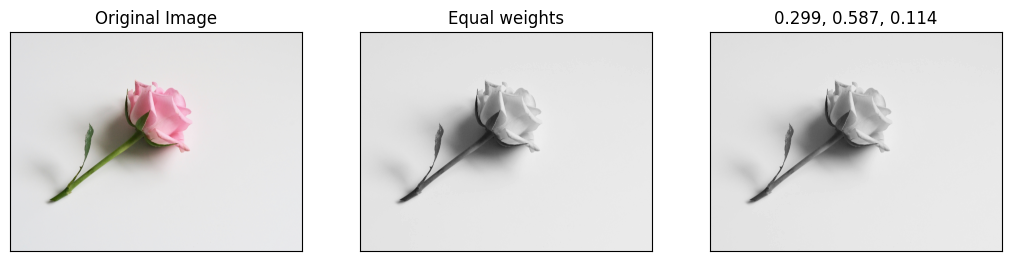

In [8]:
show_images(
    (image, "Original Image"),
    (to_greyscale(image, (1 / 3, 1 / 3, 1 / 3)), "Equal weights"),
    (to_greyscale(image, (0.299, 0.587, 0.114)), "0.299, 0.587, 0.114"),
)

## Normalized RGB

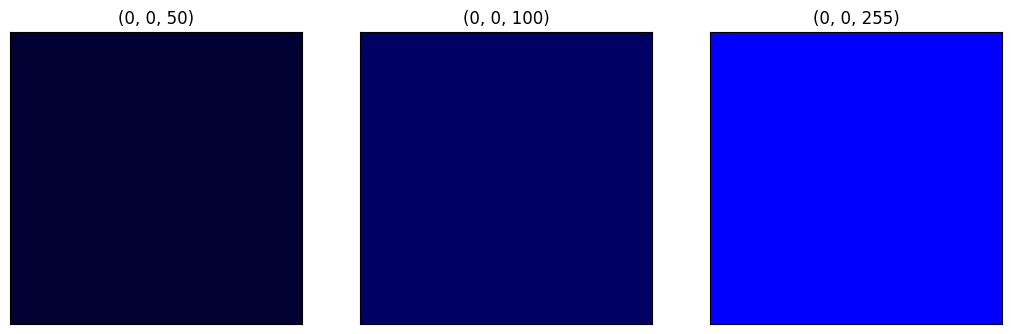

In [9]:
def make_image(colours, shape=(30, 30)):
    return np.stack(
        (
            colours[0] * np.ones(shape, dtype=np.int32),
            colours[1] * np.ones(shape, dtype=np.int32),
            colours[2] * np.ones(shape, dtype=np.int32),
        ),
        axis=2,
    )


show_images(
    [
        (make_image((0, 0, 50)), "(0, 0, 50)"),
        (make_image((0, 0, 100)), "(0, 0, 100)"),
        (make_image((0, 0, 255)), "(0, 0, 255)"),
    ]
)

Notice that (0, 0, 50), (0, 0, 100) and even (0, 0, 255) all displays the same colour of blue, but at different intensity.
Thus, we can represent the RGB scale as a normalized rgb scale, where
$$
(r,g,b) = \left(\frac{R}{R+G+B}, \frac{G}{R+G+B}, \frac{B}{R+G+B}\right)
$$
With this image, all pixels have the same intensity.

In [10]:
from module.point_process import normalize

show_implementation(normalize)

def normalize(img):
    return img / np.repeat(np.sum(img, axis=2)[:, :, np.newaxis], 3, axis=2)


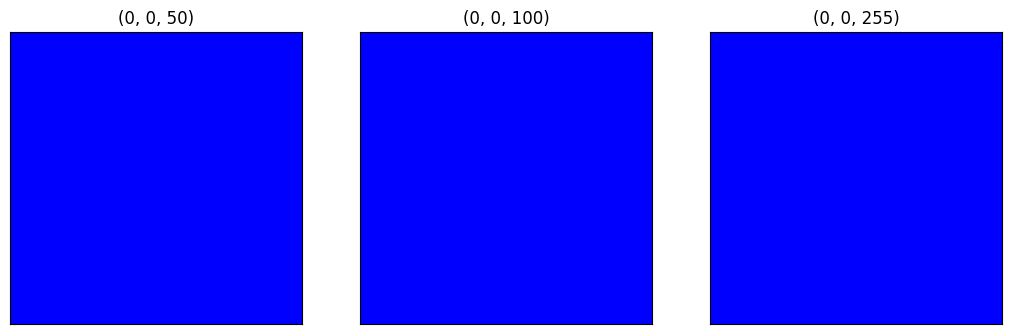

In [11]:
show_images(
    (normalize(make_image((0, 0, 50))), "(0, 0, 50)"),
    (normalize(make_image((0, 0, 100))), "(0, 0, 100)"),
    (normalize(make_image((0, 0, 255))), "(0, 0, 255)"),
)

As we can see, after normalizing, all the images looks the same.


## <span id="intensity-vs-colour"/>Intensity vs Colour
It is to note that intensity "carries more information" than colour.

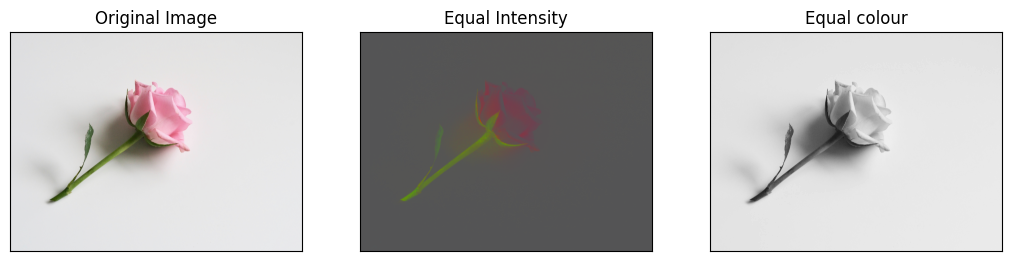

In [12]:
show_images(
    (image, "Original Image"),
    (normalize(image), "Equal Intensity"),
    (to_greyscale(image, (1 / 3, 1 / 3, 1 / 3)), "Equal colour"),
)

As we can see, we can make out the details rose in the greyscale image even though there is not variation in colour.
It is hard to see the details when the image have equal intensity but different colour.
Thus, this provides evidence to our claim that intensity carries more information than colour in an image.

## HSV Colourspace
HSV colourspace corresponds to the Hue, Saturation, Value colourspace.

Hue determines the colour of the pixel.

Saturation determines the "purity" of the pixel, which is the amount of colour is in that pixel.
Lower value indicate that it is more "faded".
One can visualize this as the amount of paint added to a colour.

Value determines the "brightness" of the pixel.
Lower value indicate that it is closer to black.
One can visualize this as the amount of light being shone on the pixel.


The formula to derive the HSV from RGB is as below

$$
M = \min(R,G,B)
$$
$$
V = \max(R,G,B)
$$
$$
S = \frac{V-M}{V}
$$
$$
H = 
\begin{cases}
\frac{G-B}{V-M} \times 60^\circ, \qquad \text{if } V = R \text { and } G \geq B\\
(\frac{B-R}{V-M} + 2) \times 60^\circ, \text{if } G = V \\
(\frac{R-G}{V-M} + 4) \times 60^\circ, \text{if } B = V \\
(\frac{R-B}{V-M} + 5) \times 60^\circ, \text{if } V = R \text{ and } G < B
\end{cases}
$$

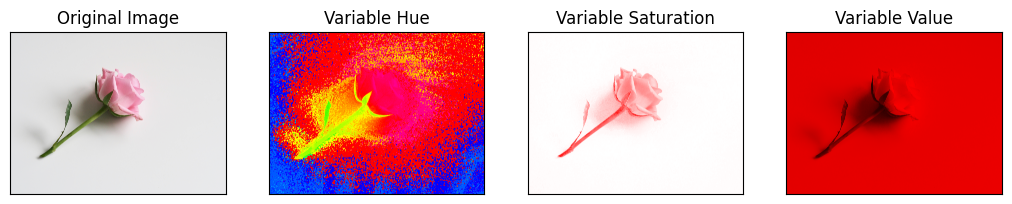

In [13]:
from matplotlib.colors import hsv_to_rgb

hsv_image = rose_image_rgb.convert("HSV")
hsv_image = np.array(hsv_image, dtype=np.float32)


def mask_channel(image, channel):
    new_image = np.copy(image)
    for i in range(3):
        if i != channel:
            new_image[:, :, i] = np.ones(image.shape[:2])
    return new_image


show_images(
    (hsv_to_rgb(hsv_image / 255), "Original Image"),
    (hsv_to_rgb(mask_channel(hsv_image / 255, 0)), "Variable Hue"),
    (hsv_to_rgb(mask_channel(hsv_image / 255, 1)), "Variable Saturation"),
    (hsv_to_rgb(mask_channel(hsv_image / 255, 2)), "Variable Value"),
)

For the 2nd image, since the saturation and value is constant, the blue component present in the white background becomes more pronounced.

For the 3rd and 4th image, since the hue is fixed, they have a red tint.
For the 3rd image, it shows which part of the image has the most saturated colour, while the 4th image shows which part is the most illuminated by light